# Customer Segmentation using Spark
Customer segmentation is a marketing technique companies use to identify and group users who display similar characteristics. In this project, I am using Spark with Python i-e PySpark for building the customer segmentation model

## Dataset Used:
ecommerce-dataset

### Imports

In [37]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
# For standarization
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
# For ML model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
# For visualization
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Creating a SparkSession
A SparkSession is an entry point into all functionality in Spark, and is required if you want to build a dataframe in PySpark

In [2]:
spark = SparkSession.builder.appName("Customer Segmentation Spark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

Using the codes above, we built a spark session and set a name for the application. Then, the data was cached in off-heap memory to avoid storing it directly on disk, and the amount of memory was manually specified.

### 2. Creating a DataFrame using Spark

In [3]:
df = spark.read.csv('ecommerce_data.csv',header=True,escape="\"")

Note that we defined an escape character to avoid commas in the .csv file when parsing.

In [4]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/2010 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/2010 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/2010 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------

In [5]:
columns = df.columns 
columns

['InvoiceNo',
 'StockCode',
 'Description',
 'Quantity',
 'InvoiceDate',
 'UnitPrice',
 'CustomerID',
 'Country']

The dataframe consists of 8 variables:  
InvoiceNo: The unique identifier of each customer invoice.  
StockCode: The unique identifier of each item in stock.  
Description: The item purchased by the customer.  
Quantity: The number of each item purchased by a customer in a single invoice.  
InvoiceDate: The purchase date.  
UnitPrice: Price of one unit of each item.  
CustomerID: Unique identifier assigned to each user.  
Country: The country from where the purchase was made  

### 3. Exploratory Data Analysis

Counting the total rows in dataset

In [6]:
df.count()

541909

Counting the number of unique customers present in dataframe

In [7]:
df.select('CustomerID').distinct().count()

4373

Finding the country from where the most purchases are made using groupby

In [8]:
df.head(5)

[Row(InvoiceNo='536365', StockCode='85123A', Description='WHITE HANGING HEART T-LIGHT HOLDER', Quantity='6', InvoiceDate='12/1/2010 8:26', UnitPrice='2.55', CustomerID='17850', Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='71053', Description='WHITE METAL LANTERN', Quantity='6', InvoiceDate='12/1/2010 8:26', UnitPrice='3.39', CustomerID='17850', Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84406B', Description='CREAM CUPID HEARTS COAT HANGER', Quantity='8', InvoiceDate='12/1/2010 8:26', UnitPrice='2.75', CustomerID='17850', Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84029G', Description='KNITTED UNION FLAG HOT WATER BOTTLE', Quantity='6', InvoiceDate='12/1/2010 8:26', UnitPrice='3.39', CustomerID='17850', Country='United Kingdom'),
 Row(InvoiceNo='536365', StockCode='84029E', Description='RED WOOLLY HOTTIE WHITE HEART.', Quantity='6', InvoiceDate='12/1/2010 8:26', UnitPrice='3.39', CustomerID='17850', Country='United Kingdom')]

In [9]:
df.tail(5)

[Row(InvoiceNo='581587', StockCode='22613', Description='PACK OF 20 SPACEBOY NAPKINS', Quantity='12', InvoiceDate='12/9/2011 12:50', UnitPrice='0.85', CustomerID='12680', Country='France'),
 Row(InvoiceNo='581587', StockCode='22899', Description="CHILDREN'S APRON DOLLY GIRL ", Quantity='6', InvoiceDate='12/9/2011 12:50', UnitPrice='2.1', CustomerID='12680', Country='France'),
 Row(InvoiceNo='581587', StockCode='23254', Description='CHILDRENS CUTLERY DOLLY GIRL ', Quantity='4', InvoiceDate='12/9/2011 12:50', UnitPrice='4.15', CustomerID='12680', Country='France'),
 Row(InvoiceNo='581587', StockCode='23255', Description='CHILDRENS CUTLERY CIRCUS PARADE', Quantity='4', InvoiceDate='12/9/2011 12:50', UnitPrice='4.15', CustomerID='12680', Country='France'),
 Row(InvoiceNo='581587', StockCode='22138', Description='BAKING SET 9 PIECE RETROSPOT ', Quantity='3', InvoiceDate='12/9/2011 12:50', UnitPrice='4.95', CustomerID='12680', Country='France')]

In [10]:
df_grouped_country = df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|        Denmark|            9|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|         Sweden|            8|
|         Cyprus|            8|
|          Japan|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



From this table it can be seen that almost all the purchases on platform were made in UK

Finding the date of most recent purchase by customer in e-commerce platform

In [11]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'dd/MM/yy HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2011-12-10 17:19:00|
+-------------------+



In [12]:
df.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|               date|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+-------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|2010-01-12 08:26:00|
|   536365|    2

New column date was added to this dataframe based on InvoiceDate column which has date in proper format

Finding the earliest purchase made by customer on e-commerce platform

In [13]:
df.select(min('date')).show()

+-------------------+
|          min(date)|
+-------------------+
|2010-01-12 08:26:00|
+-------------------+



### 4. Data Pre-Processing
RFM is commonly used in marketing to evaluate a client’s value based on their:

Recency: How recently has each customer made a purchase?  
Frequency: How often have they bought something?  
Monetary Value: How much money do they spend on average when making purchases?  

We now preprocess the dataframe to create above variables

Assign Recency score to each customer

In [14]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

Select the most recent purchase

In [15]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')


In [16]:
df2.show(5,0)

+---------+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|recency  |InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|CustomerID|Country       |date               |from_date          |
+---------+---------+---------+-----------------------------------+--------+--------------+---------+----------+--------------+-------------------+-------------------+
|-62893980|536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/2010 9:53|6.45     |18074     |United Kingdom|2010-01-12 09:53:00|2012-01-10 08:26:00|
|-62893980|536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/2010 9:53|0.65     |18074     |United Kingdom|2010-01-12 09:53:00|2012-01-10 08:26:00|
|-62893980|536384   |22464    |HANGING METAL HEART LANTERN        |12      |12/1/2010 9:53|1.65     |18074     |United Kingdom|2010-01-12 09:53:00|2012-01-10 08

An easier way to view all the variables present in a PySpark dataframe is to use its printSchema() function. This is the equivalent of the info() function in Pandas:

In [17]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



https://www.datacamp.com/tutorial/pyspark-tutorial-getting-started-with-pyspark

Calculating the frequency of purchase i-e how often a customer bought something on the platform

In [18]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|16250     |14       |
|15574     |121      |
|13187     |37       |
|13107     |21       |
|16303     |35       |
+----------+---------+
only showing top 5 rows



Joining this new dataframe with the previous dataframe df2 to append frequency value to each customer in database.

In [19]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



Calculating the monetary value - the total amount soent by each customer in the dataframe

Finding the total amount spent in each purchase. Each customerID comes with variables like "Quantity" ad "UnitPice". Then to get the total amount spent by each customer in one purchase, we multiply the quantity and unit price

In [20]:
m_val = df3.withColumn('TotalAmount',col("Quantity")*col("UnitPrice"))

In [21]:
m_val.show(3,0)

+----------+---------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|CustomerID|recency  |InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate   |UnitPrice|Country       |date               |from_date          |frequency|TotalAmount       |
+----------+---------+---------+---------+-----------------------------------+--------+--------------+---------+--------------+-------------------+-------------------+---------+------------------+
|18074     |-62893980|536384   |82484    |WOOD BLACK BOARD ANT WHITE FINISH  |3       |12/1/2010 9:53|6.45     |United Kingdom|2010-01-12 09:53:00|2012-01-10 08:26:00|13       |19.35             |
|18074     |-62893980|536384   |84755    |COLOUR GLASS T-LIGHT HOLDER HANGING|48      |12/1/2010 9:53|0.65     |United Kingdom|2010-01-12 09:53:00|2012-01-10 08:26:00|13       |31.200000000000003|
|18074     |-62

Then to find the total amount spend by the customer is to find the total amount spent by each customer overall using groupBy

In [22]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [23]:
m_val.show(3,0)

+----------+------------------+
|CustomerID|monetary_value    |
+----------+------------------+
|16250     |226.14            |
|15574     |375.65            |
|13187     |236.01999999999995|
+----------+------------------+
only showing top 3 rows



Merge this dataframe with all other variables

In [24]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

Creating final dataframe for training model

In [25]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [26]:
finaldf.show(3,0)

+---------+---------+------------------+----------+
|recency  |frequency|monetary_value    |CustomerID|
+---------+---------+------------------+----------+
|-62893620|14       |226.14            |16250     |
|-60194400|121      |375.65            |15574     |
|-19229340|37       |236.01999999999995|13187     |
+---------+---------+------------------+----------+
only showing top 3 rows



Standarization: Done to standarize and ensure that the values of all varibles are under same scale

In [27]:
assemble = VectorAssembler(inputCols=['recency','frequency','monetary_value'],outputCol='features')

assembled_data = assemble.transform(finaldf)

scale = StandardScaler(inputCol='features',outputCol='standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

First, a VectorAssembler object is created with the input columns recency, frequency, and monetary_value, and the output column features. This object will combine the three input columns into a single vector column.

Next, the assemble object is applied to the finaldf DataFrame using the transform method. This will create a new DataFrame called assembled_data that includes the original columns as well as the new features column.

Then, a StandardScaler object is created with the input column features and the output column standardized. This object will scale the values in the features column so that they have zero mean and unit standard deviation.

Finally, the data_scale object is fit to the assembled_data DataFrame using the fit method, and then applied to the DataFrame using the transform method. This will create a new DataFrame called data_scale_output that includes the original columns, the features column, and a new standardized column with the scaled values.

Display standardized feature vector

In [28]:
data_scale_output.select('standardized').show(2,truncate=False)

+------------------------------------------------------------+
|standardized                                                |
+------------------------------------------------------------+
|[-5.145941858188064,0.45450804304970116,0.07578116853200018]|
|[-4.92509228421763,3.9282480863581313,0.1258830634078264]   |
+------------------------------------------------------------+
only showing top 2 rows



Building machine learing model

1. Finding number of clusters to use
For performing K Means clustering we first need to determine the number of clusters to be created for which we use the elbow method

In [31]:
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction',featuresCol='standardized',metricName='silhouette',distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_model = KMeans(featuresCol='standardized',k=i)
    KMeans_fit = KMeans_model.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

In the above code we have successfully built and evaluated K-Means clustering model with 2 to 10 clusters. The results are placed in an array and will be visualized using a line chart.

Explanation
First, a NumPy array cost of length 10 is initialized with all zeros. This array will be used to store the K-means training costs for different numbers of clusters.

Then, a ClusteringEvaluator object is created with the prediction column set to 'prediction', the features column set to 'standardized', and the metric name set to 'silhouette'. This object will be used to evaluate the quality of the clustering results.

Next, a loop is executed over the range of 2 to 9 (inclusive). For each value of i, a KMeans object is created with the features column set to 'standardized' and the number of clusters set to i. The KMeans object is then fitted to the data_scale_output DataFrame using the fit method, and the resulting model is used to transform the DataFrame and generate cluster assignments using the transform method.

The training cost of the K-means model is then computed using the summary.trainingCost attribute, and stored in the cost array at index i.

After the loop completes, the cost array will contain the training costs for K-means models with 2 to 9 clusters, and can be used to determine the optimal number of clusters based on a trade-off between model complexity and clustering performance.




Visualizing the no of clusters i-e elbow method

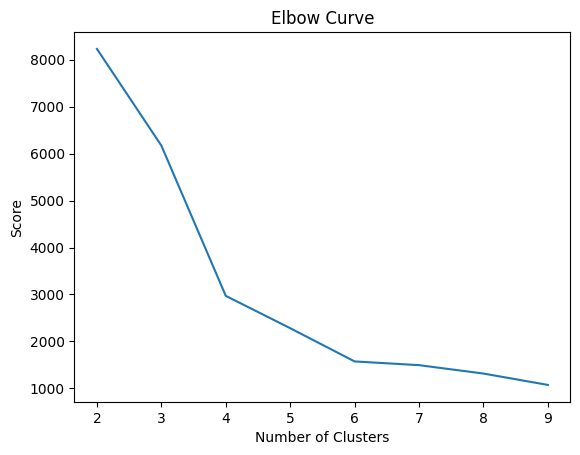

In [33]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Building K-Means clustering model
From above plot it can be seen that the inflection point that looks like an elbow at four

In [34]:
KMeans_algo=KMeans(featuresCol='standardized', k=4)
KMeans_fit=KMeans_algo.fit(data_scale_output)

Making predictions

In [35]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+---------+---------+------------------+----------+-------------------------------------+------------------------------------------------------------+----------+
|recency  |frequency|monetary_value    |CustomerID|features                             |standardized                                                |prediction|
+---------+---------+------------------+----------+-------------------------------------+------------------------------------------------------------+----------+
|-62893620|14       |226.14            |16250     |[-6.289362E7,14.0,226.14]            |[-5.145941858188064,0.45450804304970116,0.07578116853200018]|2         |
|-60194400|121      |375.65            |15574     |[-6.01944E7,121.0,375.65]            |[-4.92509228421763,3.9282480863581313,0.1258830634078264]   |1         |
|-19229340|37       |236.01999999999995|13187     |[-1.922934E7,37.0,236.01999999999995]|[-1.573340278574044,1.2011998280599245,0.07909202881808913] |0         |
|-8711880 |21       |566.840

Cluster analysis
Here we use the following lines of code to visualize the recency, frequency, and monetary value of each customerID in the dataframe:

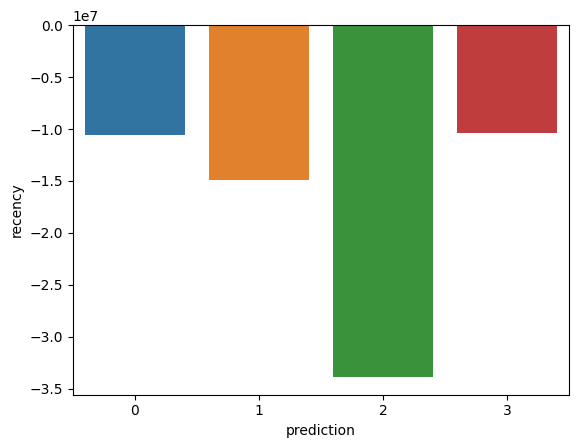

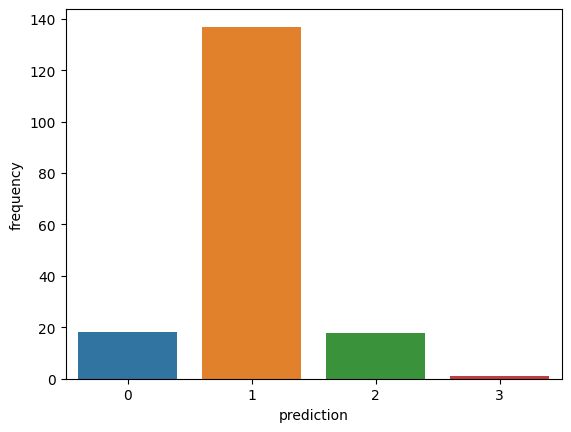

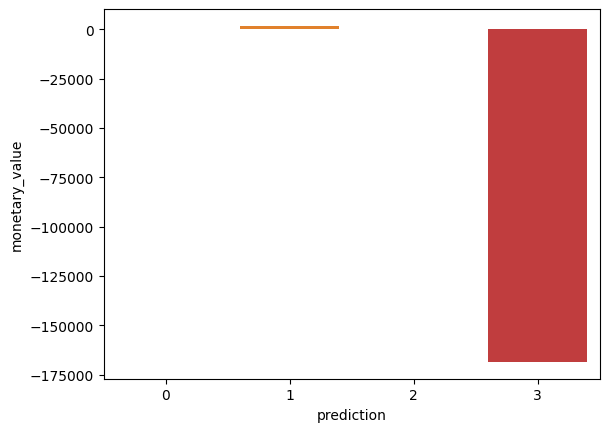

In [38]:
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

Not sure about this, visualization not looking good for some reasons
Here is an overview of characteristics displayed by customers in each cluster:

Cluster 0: Customers in this segment display low recency, frequency, and monetary value. They rarely shop on the platform and are low potential customers who are likely to stop doing business with the ecommerce company.    
Cluster 1: Users in this cluster display high recency but haven’t been seen spending much on the platform. They also don’t visit the site often. This indicates that they might be newer customers who have just started doing business with the company.    
Cluster 2: Customers in this segment display medium recency and frequency and spend a lot of money on the platform. This indicates that they tend to buy high-value items or make bulk purchases.    
Cluster 3: The final segment comprises users who display high recency and make frequent purchases on the platform. However, they don’t spend much on the platform, which might mean that they tend to select cheaper items in each purchase.    